# <center>Dantzig-Wolfe decomposition</center>
### <center>Alfred Galichon (NYU & Sciences Po)</center>
## <center>'math+econ+code' masterclass series</center>
#### <center>With python code examples</center>
© 2018–2023 by Alfred Galichon. Past and present support from NSF grant DMS-1716489, ERC grant CoG-866274 are acknowledged, as well as inputs from contributors listed [here](http://www.math-econ-code.org/team).

**If you reuse material from this masterclass, please cite as:**<br>
Alfred Galichon, 'math+econ+code' masterclass series. https://www.math-econ-code.org/


### References

* Dantzig, G.B. and Wolfe, P. (1960). "Decomposition Principle for Linear Programs". *Operations Research*. 8: 101–111.

* Luenberger, D. and Ye, Y. (2008). *Linear and Nonlinear Optimization*. Springer.

In [6]:
import numpy as np
from mec.lp import Tableau
import gurobipy as grb


In [2]:
class Pivoter():
    def __init__(self,B_i_b,x_b):
        self.nbb = B_i_b.shape[0]
        self.B_i_b = B_i_b
        self.x_b = x_b
    
    def determine_departing(self,Nent_i):
        z_b = np.linalg.solve(self.B_i_b,Nent_i) 
        thedic = {b: self.x_b[b] / z_b[b] for b in range(self.nbb) if z_b[b]>0}
        bdep = min(thedic, key = thedic.get)
        epsilon = thedic[bdep]
        return bdep,epsilon
    
    def update(self,bdep,epsilon,Nent_i):
        self.x_b = self.x_b - epsilon * np.linalg.solve(self.B_i_b,Nent_i) 
        self.x_b[bdep] = epsilon
        self.B_i_b[:,bdep] = Nent_i

In [41]:
class DantzigWolfe():
    def __init__(self,Lks,b0_i,Aks,bks,cks):
        self.nbk = len(Lks)
        self.nbi0 = Lks[0].shape[0]
        self.nbb = self.nbk + self.nbi0
        self.Lks = Lks
        self.b0_i = b0_i
        self.Aks = Aks
        self.bks = bks
        self.cks = cks
        self.pivot = None
        
    def solve_gurobi(self,outputFlag=0):
        m=grb.Model()
        m.setParam('OutputFlag', outputFlag)
        xks = [m.addMVar(len(self.cks)) for k in range(self.nbk)]
        m.setObjective(sum ([ self.cks[k] @ xks[k] for k in range(self.nbk)]) ,sense = grb.GRB.MAXIMIZE)
        linking_constr = m.addConstr(sum ([ self.Lks[k] @ xks[k] for k in range(self.nbk)]) == self.b0_i)
        local_constrs = [m.addConstr(self.Aks[k] @xks[k] <= self.bks[k] ) for k in range(self.nbk)]
        m.optimize()
        print('objVal=',m.objVal)
        for k in range(self.nbk):
            print('x'+str(k)+'_j=',xks[k].x)

        
    def init_feasible(self,xbs, kbs, alphabs):
        self.xbs = xbs
        self.kbs = kbs
        Qbs = [np.concatenate([self.Lks[kbs[b]] @ xbs[b],np.array([1.0 if i == kbs[b] else 0.0 for i in range(self.nbk)])]) for b in range(self.nbb)]
        self.pivot = Pivoter(np.column_stack(Qbs),np.array(alphabs))
        

    def determine_entering(self,verbose = 0):
        p_b = np.array([  cks[self.kbs[b] ].dot(self.xbs[b] ) for b in range(self.nbb) ])
        if verbose>0:
            print('Objective=',self.pivot.x_b@p_b)
        y = np.linalg.solve(self.pivot.B_i_b.T,p_b)

        themax = -np.inf
        kstar,xstar = None,None
        for k in range(nbk):
            x,obj = subproblem_solve(self.Aks[k],self.bks[k],self.cks[k] - self.Lks[k].T @ y[:nbi0] )
            if  obj-y[nbi0+k] > themax: 
                themax,kstar,xstar_j = obj-y[nbi0+k],k,x
        if (themax > -np.inf) & (themax > 0):
            Nent_i =  np.concatenate( [self.Lks[kstar] @  xstar_j , np.array([1.0 if i == kstar else 0.0 for i in range(self.nbk)]) ])
            return (True,xstar_j,kstar,Nent_i)
        else:
            return(False,None,None,None)
        
    def determine_departing(self,Nent_i):
        return self.pivot.determine_departing(Nent_i)
    
    def update(self,x_j,kent,Nent_i,bdep,epsilon):
        self.xbs[bdep] = x_j
        self.kbs[bdep] = kent
        self.pivot.update(bdep,epsilon,Nent_i)
        
        

In [33]:
def subproblem_solve(A_i_j,b_i,c_j,outputFlag=0):
    nbi,nbj = A_i_j.shape
    m = grb.Model()
    m.setParam('OutputFlag', outputFlag)
    x_j = m.addMVar(nbj)
    m.addConstr(A_i_j@x_j <= b_i)
    m.setObjective(c_j@x_j,sense = grb.GRB.MAXIMIZE )
    m.optimize()
    return x_j.x,m.objVal


Consider
\begin{eqnarray*}
\min_{x_{k}\geq 0} &&\sum_{k=1}^Kc_{k}^{\top }x_{k} \\
s.t.~ &&L_{1}x_{1}+...+L_{K}x_{k}=b_{0} \\
&&A_{kk}x_{k}=b_{k},k=1,...,K
\end{eqnarray*}


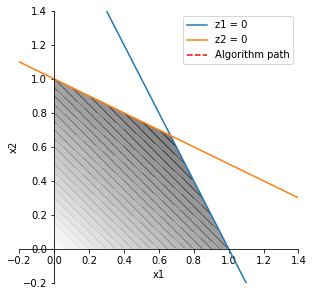

In [7]:
A1_i_j = np.array([[2, 1], [1, 2]])
b1list = [2,2]
b1_i = np.array(b1list)
c1_j = np.array([2,2])
t1 = Tableau(['s11','s12'],['x11','x12'], A1_i_j,[2,2],c1_j)
t1.plot_path_so_far([])

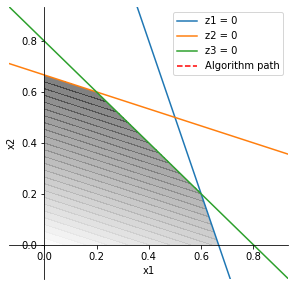

In [8]:
A2_i_j = np.array([[3, 1], [1, 3], [5,5]])
b2list = [2,2,4]
b2_i = np.array(b2list)
c2_j = np.array([1,3])
t2 = Tableau(['s21','s22','s23'],['x21','x22'], A2_i_j,b2list,c2_j)
t2.plot_path_so_far([])

For the linking constraint, we take:

In [42]:
Lks = [np.array([[2,1]]),np.array([[1,3]])]
b0_i = np.array([1])
Aks = [A1_i_j,A2_i_j]
bks = [b1_i,b2_i]
cks = [c1_j,c2_j]
nbk= len(Lks)
nbi0 = Lks[0].shape[0]
ls_program = DantzigWolfe(Lks,b0_i,Aks,bks,cks)

# Solving the problem

We solve using Gurobi for reference and we find:

In [10]:
ls_program.solve_gurobi()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-12
objVal= 2.0
x0_j= [0. 1.]
x1_j= [0. 0.]


Now we are back to the simplex. Let's compute the initial basis. We take 


In [53]:
ls_program.init_feasible(xbs = [np.zeros(2),np.array([1,0]),np.zeros(2)], #feasible solutions of program k
                         kbs = [0,0,1], # corresponding k
                         alphabs = [0.5,0.5,1]) #weights    

We see that a basic feasible solution is a mix of columns 

In [56]:
cont,x_j,kstar,Nent_i=ls_program.determine_entering(verbose=True)
if cont:
    bdep,epsilon = ls_program.determine_departing(Nent_i)
    ls_program.update(x_j,kstar,Nent_i,bdep,epsilon)
    print(ls_program.pivot.x_b)
else:
    print('Optimal solution.')

Objective= 2.0
Optimal solution.
